<a href="https://colab.research.google.com/github/Gregtom3/vossen_ecal_ai/blob/main/notebooks/nb01_falsePhotons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial Overview

In this section, we showcase the basic machine learning approach to resolving the false photon problem at CLAS12. We follow along with the event data collected by the `hipo2tree.C` program in [the photon AI repo](https://github.com/Gregtom3/clas12_photon_classifier). The event data was collected using a Monte Carlo event generator with simulated detector readouts in Geant4. Particles are reconstructed using the Coatjava framework.

## Imports

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

## Data loading
Here we use `pandas` to extract the photon CSV data from the GitHub.

There are 3 CSV files, intended for the `train`, `test` and `validation` sets.

In [15]:

# Define URLs for train, test, and validation datasets
train_url = "https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/data/false_photons/photon_data_train.csv"
test_url = "https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/data/false_photons/photon_data_test.csv"
validation_url = "https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/data/false_photons/photon_data_validation.csv"

# ---------------------------
# Load Training Data
# ---------------------------
df_train = pd.read_csv(train_url)
print("Train DataFrame:")
display(df_train)
print("Total number of photons =", len(df_train))
print("Total number of events =", len(df_train['event'].unique()))

# Get input columns by excluding these unwanted columns
columns_train = list(df_train.columns)
input_columns = [col for col in columns_train if col not in ['event', 'y', 'truepid', 'trueparentpid', 'trueparentid']]

X_train = df_train[input_columns]
y_train = df_train['y']
event_train = df_train['event']

# ---------------------------
# Load Test Data
# ---------------------------
df_test = pd.read_csv(test_url)
print("\nTest DataFrame:")
display(df_test)
print("Total number of photons =", len(df_test))
print("Total number of events =", len(df_test['event'].unique()))

columns_test = list(df_test.columns)
input_columns_test = [col for col in columns_test if col not in ['event', 'y', 'truepid', 'trueparentpid', 'trueparentid']]

X_test = df_test[input_columns_test]
y_test = df_test['y']
event_test = df_test['event']

# ---------------------------
# Load Validation Data
# ---------------------------
df_validation = pd.read_csv(validation_url)
print("\nValidation DataFrame:")
display(df_validation)
print("Total number of photons =", len(df_validation))
print("Total number of events =", len(df_validation['event'].unique()))

columns_validation = list(df_validation.columns)
input_columns_val = [col for col in columns_validation if col not in ['event', 'y', 'truepid', 'trueparentpid', 'trueparentid']]

X_validation = df_validation[input_columns_val]
y_validation = df_validation['y']
event_validation = df_validation['event']

Train DataFrame:


,event,truepid,trueparentpid,trueparentid,y,gE,gTheta,gPhi,gEpcal,gm2u,...,R_nh_0,R_nh_1,dE_nh_0,dE_nh_1,Epcal_nh_0,Epcal_nh_1,m2u_nh_0,m2u_nh_1,m2v_nh_0,m2v_nh_1
0,1,-999,-999,-999,0,2.910594,0.101350,-0.262233,0.652126,22.783363,...,0.519021,0.519147,1.709837,1.705969,0.0,0.0,0.0,0.0,0.0,0.0
1,1,22,111,9,1,2.148248,0.146735,-0.223929,0.325878,3.062976,...,0.543572,0.545547,0.943624,0.947492,0.0,0.0,0.0,0.0,0.0,0.0
2,4,-999,-999,-999,0,0.566051,0.121903,0.093918,0.036311,16.345917,...,0.100247,0.000000,-1.218411,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,-999,-999,-999,0,0.486396,0.369209,-0.778430,0.024489,0.375000,...,0.406219,0.000000,-1.298065,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,4,-999,-999,-999,0,0.432689,0.204312,3.072738,0.095784,3.812810,...,0.299216,0.000000,-1.351772,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5946,-999,-999,-999,0,0.590003,0.446021,-0.084567,0.136522,102.580002,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9996,5946,-999,-999,-999,0,0.442394,0.448664,-0.094443,0.098303,102.580002,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9997,5946,-999,-999,-999,0,0.418388,0.448463,-0.063126,0.092070,102.580002,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9998,5950,22,111,14,1,1.164242,0.111871,-0.140896,0.168634,9.962226,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Total number of photons = 10000
Total number of events = 3341

Test DataFrame:


,event,truepid,trueparentpid,trueparentid,y,gE,gTheta,gPhi,gEpcal,gm2u,...,R_nh_0,R_nh_1,dE_nh_0,dE_nh_1,Epcal_nh_0,Epcal_nh_1,m2u_nh_0,m2u_nh_1,m2v_nh_0,m2v_nh_1
0,0,-999,-999,-999,0,1.724388,0.227431,-0.991334,0.390787,55.514355,...,0.050580,0.072295,-0.105695,-0.364223,0.0,0.0,0.0,0.0,0.0,0.0
1,0,-999,-999,-999,0,1.186435,0.202977,1.245790,0.235489,13.686324,...,0.365951,0.367520,-0.902176,-0.643648,0.0,0.0,0.0,0.0,0.0,0.0
2,5,22,111,13,1,0.412888,0.415785,-3.013918,0.090641,8.847053,...,0.209284,0.000000,-0.642517,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,5,-999,-999,-999,0,0.225602,0.122878,-0.971362,0.041615,0.375000,...,0.553518,0.000000,-0.829802,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,6,22,111,14,1,0.541043,0.362009,-2.086100,0.067221,13.311428,...,0.650785,0.000000,-0.982799,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5724,-999,-999,-999,0,0.235341,0.208082,-1.148132,0.044184,0.375000,...,0.608200,0.611293,-0.976456,-0.988846,0.0,0.0,0.0,0.0,0.0,0.0
9996,5725,22,111,12,1,0.489576,0.545817,-0.462844,0.110536,12.870308,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9997,5725,22,111,12,1,0.375694,0.376440,0.228472,0.080966,7.140016,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9998,5725,-999,-999,-999,0,0.204295,0.369468,-0.101184,0.036005,7.140016,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Total number of photons = 10000
Total number of events = 3321

Validation DataFrame:


,event,truepid,trueparentpid,trueparentid,y,gE,gTheta,gPhi,gEpcal,gm2u,...,R_nh_0,R_nh_1,dE_nh_0,dE_nh_1,Epcal_nh_0,Epcal_nh_1,m2u_nh_0,m2u_nh_1,m2v_nh_0,m2v_nh_1
0,0,-999,-999,-999,0,0.386794,0.152488,-1.911128,0.083856,9.882128,...,0.182176,0.190280,-0.785452,-0.777435,0.027883,0.035883,0.375,0.375,0.375,0.375
1,0,-999,-999,-999,0,0.322163,0.379644,-1.338685,0.066997,0.375000,...,0.439822,0.446627,-0.850084,-0.842066,0.027883,0.035883,0.375,0.375,0.375,0.375
2,1,22,111,20,1,0.929126,0.114495,-2.072028,0.179433,6.048819,...,0.327752,0.334054,-1.119416,-0.959130,0.000000,0.000000,0.000,0.000,0.000,0.000
3,1,-999,-999,-999,0,0.849298,0.447338,-1.995302,0.203443,83.464142,...,0.661775,0.667741,-1.199244,-1.038958,0.000000,0.000000,0.000,0.000,0.000,0.000
4,1,-999,-999,-999,0,0.412125,0.476923,-2.480103,0.090443,83.464142,...,0.669774,0.680748,-1.636417,-1.476131,0.000000,0.000000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5894,-999,-999,-999,0,1.047429,0.515151,2.097297,0.072536,95.443810,...,0.024197,0.042382,-0.426481,-0.328467,0.000000,0.000000,0.000,0.000,0.000,0.000
9996,5894,-999,-999,-999,0,0.397374,0.518173,2.085378,0.066734,95.443810,...,0.030784,0.046762,-1.076536,-0.978523,0.000000,0.000000,0.000,0.000,0.000,0.000
9997,5896,22,111,10,1,2.392195,0.234196,-0.249523,0.280099,10.332424,...,0.077514,0.000000,0.594749,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.000
9998,5896,22,111,10,1,1.827655,0.287773,-0.395033,0.392839,8.891359,...,0.035345,0.000000,0.030209,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.000


Total number of photons = 10000
Total number of events = 3353


## Explanation of Data

We describe the contents of the dataframe's columns. Each row describes a single photon found in an event, and the columns are that photons features which we may use during training. Many of these features are concerned with the nearest neighbors of the photon, which we elaborate more on below.

Below, $\mathrm{PARTICLE}\in[\mathrm{gamma},\mathrm{ch},\mathrm{nh}]$ where 'gamma' represents photons, 'ch' represents (any) charged hadron, and 'nh' represents (any) neutral hadron. The value $\mathrm{NUM}\in[0,1]$ for 'ch', 'nh' and $\mathrm{NUM}\in[0,1,2]$ designates the index of the nearest neighbor for that photon.

For instance, consider `dE_gamma_1`. This is the energy difference between the photon and its 2 closest neighboring photon. If there were only 2 photons in that event, then `dE_gamma_1` would be 0. All features relying on nearest neighbors are 0-padded if the number of nearest neighbors reconstructed in the event is not met.

Below are non-inputs/Monte Carlo specific information
* `event` - The event number
* `truepid` - Monte Carlo PID of the generated particle closest to the photon
* `trueparentpid` - Monte Carlo PID of the generated particle above's parent
* `trueparentid` - Identifier for the parent particle
* `y` - [0,1] labeling the reconstructed photon as true or false

Below are the inputs ...

* `gE` - Reconstructed energy of the photon
* `gTheta` - Reconstructed theta of the photon
* `gPhi` - Reconstructed phi of the photon
* `gEpcal` - PCal energy deposited by the photon cluster
* `gm2u` - 2nd moment of the photon's PCal shower shape (U direction)
* `gm2v` - 2nd moment of the photon's PCal shower shape (V direction)
* `R_e`  - Angular distance between photon and nearest electron
* `dE_e` - Energy difference between photon and nearest electron
* `R_PARTICLE_NUM` - Angular difference between photon and `NUM+1` nearest `PARTICLE`
* `dE_PARTICLE_NUM`- Energy difference between photon and `NUM+1` nearest `PARTICLE`
* `Epcal_PARTICLE_NUM` - PCal energy deposited by `NUM+1` nearest `PARTICLE`
* `m2u_PARTICLE_NUM` - 2nd moment of PCal shower deposited by `NUM+1` nearest `PARTICLE` (U direction)
* `m2v_PARTICLE_NUM` - 2nd moment of PCal shower deposited by `NUM+1` nearest `PARTICLE` (V direction)


Now, lets plot some of these distributions to get a better feel of the data.

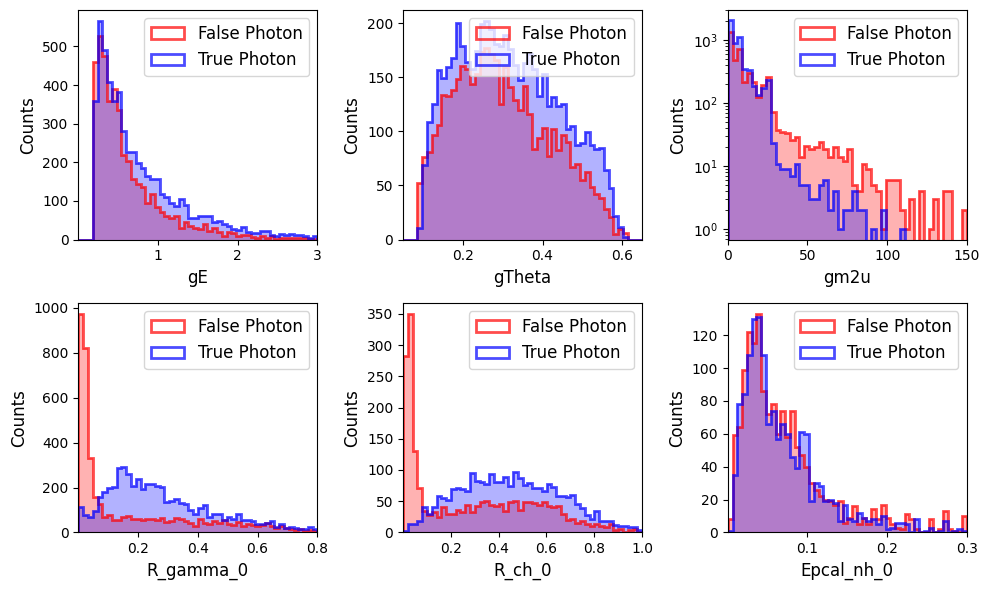

In [17]:
# ========================
# Showing the train df
# ========================

df = df_train

# Create figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Define features to plot, along with their xlimits
features = ['gE', 'gTheta', 'gm2u', 'R_gamma_0', 'R_ch_0', 'Epcal_nh_0']
xlims = [(0.001, 3), (0.05, 0.65), (0, 150), (0.001, 0.8), (0.001, 1), (0.001, 0.3)]

# Loop over all subplots
for i, ax in enumerate(axes.flat):
    feature = features[i]
    x_min = xlims[i][0]
    x_max = xlims[i][1]

    # Plot pretty histograms
    ax.hist(df[df['y'] == 0][feature], bins=50, range=(x_min,x_max), histtype='step', linewidth=2, color='red', alpha=0.7, label='False Photon')
    ax.hist(df[df['y'] == 0][feature], bins=50, range=(x_min,x_max), color='red', alpha=0.3)
    ax.hist(df[df['y'] == 1][feature], bins=50, range=(x_min,x_max), histtype='step', linewidth=2, color='blue', alpha=0.7, label='True Photon')
    ax.hist(df[df['y'] == 1][feature], bins=50, range=(x_min,x_max), color='blue', alpha=0.3)

    # Format axes
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlim(x_min, x_max)
    if feature == 'gm2u':
      ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Create legend
    ax.legend(fontsize=12)

# Plot
plt.tight_layout()
plt.show()

Above, we observe several variables, such as the angular separation of a photon and its nearest neighbor, have strong discriminating power. Others, such as the PCal energy of its nearest neutron neighbor, do not.

The false photon problem is not as complex as it may seem. It would appear we could even place hard cuts on variables like `R_gamma_0` to separate True and False photons. However, we could do even better with an AI model.

## $\pi^0$ mass

In $\pi^0$ studies, we try to create $\pi^0$'s for each event by combining two photons and calculating their invariant mass. For $N$ photons in an event, this calculation creates $C(N,2)=N(N-1)/2$ $\pi^0$'s. To illustrate the impact of false photons on $\pi^0$ reconstruction, we define what "true" $\pi^0$'s are, and their three different types of background.



1.   **True $\pi^0$** - A reconstructed diphoton pair where each photon in the pair orignated from the same $\pi^0$ decay.
2.   **Bkg Type A $\pi^0$** - A reconstructed diphoton pair where each photon in the pair originated from different $\pi^0$ decays (ex: events where two $\pi^0$'s are produced).
3.   **Bkg Type B $\pi^0$** - A reconstructed diphoton pair where one photon is false, and the other originated from a $\pi^0$ decay.
4.   **Bkg Type C $\pi^0$** - A reconstructed diphoton pair where both photons are false.

In practice, our goal is to minimize Type B and Type C backgrounds. Type A background is "ok" since it corresponds to actual combinatoric backgrounds in our experiment. It is entirely plausible for two random true photons in an event to happen upon an invariant mass near the $\pi^0$ mass. By minimizing Type B and Type C, we reduce the *false* combinatoric background.


---


In the code below, we loop over each event and extract $\pi^0$'s using the `gE`, `gTheta` and `gPhi` of the photons in the event. We plot the invariant mass distribution with lines representing the different $\pi^0$ types above.



In [18]:
def get_mass_vectors(df):

  # =============================================================================
  # Step 1: Define a function to compute the 4-vector for a photon
  # =============================================================================
  def get_4vector(gE, gTheta, gPhi):
      """
      Given a photon's energy (gE), polar angle (gTheta), and azimuthal angle (gPhi),
      calculate its momentum components (px, py, pz) and energy (E).
      """
      px = gE * np.sin(gTheta) * np.cos(gPhi)
      py = gE * np.sin(gTheta) * np.sin(gPhi)
      pz = gE * np.cos(gTheta)
      E  = gE  # For a photon, E is equal to gE (ignoring mass)
      return px, py, pz, E

  # =============================================================================
  # Step 2: Loop over all events to compute invariant masses for different categories
  # =============================================================================
  # Lists to store computed invariant masses:
  all_pi0_masses   = []  # All photon pairs (total)
  subset2_masses   = []  # Both photons: trueparentpid==111 and same trueparentid
  subset3_masses   = []  # Both photons: trueparentpid==111 but different trueparentid
  subset4_masses   = []  # One photon: trueparentpid==111 and one: trueparentpid==-999
  subset5_masses   = []  # Both photons: trueparentpid==-999

  # Get unique event numbers from the DataFrame
  events = df['event'].unique()

  # Loop over each event
  for event_num in events:
      # Filter rows corresponding to the current event
      event_photons = df[df['event'] == event_num]

      # Only consider events with at least two photons
      if len(event_photons) >= 2:
          # Iterate over all unique combinations of two photons in the event
          for photon1, photon2 in itertools.combinations(event_photons.index, 2):
              # Retrieve the data rows for each photon
              row1 = event_photons.loc[photon1]
              row2 = event_photons.loc[photon2]

              # Extract kinematic variables: energy and angles
              gE1, gTheta1, gPhi1 = row1[['gE', 'gTheta', 'gPhi']]
              gE2, gTheta2, gPhi2 = row2[['gE', 'gTheta', 'gPhi']]

              # Compute the 4-vectors for both photons
              px1, py1, pz1, E1 = get_4vector(gE1, gTheta1, gPhi1)
              px2, py2, pz2, E2 = get_4vector(gE2, gTheta2, gPhi2)

              # Sum the momentum and energy to get the total 4-momentum of the pair
              total_px = px1 + px2
              total_py = py1 + py2
              total_pz = pz1 + pz2
              total_E  = E1 + E2

              # Calculate the invariant mass (pi0 candidate mass)
              pi0_mass = np.sqrt(total_E**2 - (total_px**2 + total_py**2 + total_pz**2))
              all_pi0_masses.append(pi0_mass)

              # Extract true parent identifiers for both photons
              tp1 = row1['trueparentpid']
              tp2 = row2['trueparentpid']
              id1 = row1['trueparentid']
              id2 = row2['trueparentid']

              # Categorize the photon pair based on the true parent properties
              # Subset 2: Both photons have trueparentpid==111 and the same trueparentid
              if tp1 == 111 and tp2 == 111 and id1 == id2:
                  subset2_masses.append(pi0_mass)
              # Subset 3: Both photons have trueparentpid==111 but different trueparentid
              elif tp1 == 111 and tp2 == 111 and id1 != id2:
                  subset3_masses.append(pi0_mass)
              # Subset 4: One photon has trueparentpid==111 and the other has trueparentpid==-999
              elif (tp1 == 111 and tp2 == -999) or (tp1 == -999 and tp2 == 111):
                  subset4_masses.append(pi0_mass)
              # Subset 5: Both photons have trueparentpid==-999
              elif tp1 == -999 and tp2 == -999:
                  subset5_masses.append(pi0_mass)
  return all_pi0_masses, subset2_masses, subset3_masses, subset4_masses, subset5_masses


# Run above function to get subset of Pi0 masses
# Use the validation df
all_pi0_masses, subset2_masses, subset3_masses, subset4_masses, subset5_masses = get_mass_vectors(df_validation)

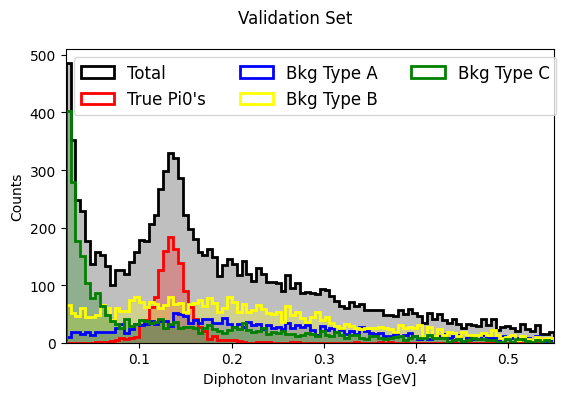

In [53]:
# Define xlimits
xlimits = (0.02,0.55)

# Define bin numbers
bins = 100

# Create figure
fig, axs = plt.subplots(1, 1, figsize=(6,4))


# Plot histograms
axs.hist(all_pi0_masses, range=xlimits, bins=bins, color="black",alpha=0.25)
axs.hist(all_pi0_masses, range=xlimits, bins=bins, color="black",histtype='step',linewidth=2, label="Total")

axs.hist(subset2_masses, range=xlimits, bins=bins, color="red",alpha=0.25)
axs.hist(subset2_masses, range=xlimits, bins=bins, color="red",histtype='step',linewidth=2, label="True Pi0's")

axs.hist(subset3_masses, range=xlimits, bins=bins, color="blue",alpha=0.25)
axs.hist(subset3_masses, range=xlimits, bins=bins, color="blue",histtype='step',linewidth=2, label="Bkg Type A")

axs.hist(subset4_masses, range=xlimits, bins=bins, color="yellow",alpha=0.25)
axs.hist(subset4_masses, range=xlimits, bins=bins, color="yellow",histtype='step',linewidth=2, label="Bkg Type B")

axs.hist(subset5_masses, range=xlimits, bins=bins, color="green",alpha=0.25)
axs.hist(subset5_masses, range=xlimits, bins=bins, color="green",histtype='step',linewidth=2, label="Bkg Type C")

# Modify axes
axs.set_xlim(xlimits)


# Plot it
plt.xlabel("Diphoton Invariant Mass [GeV]")
plt.ylabel("Counts")
plt.suptitle("Validation Set")
axs.legend(fontsize=12,ncols=3)
plt.tight_layout()
plt.show()

In the figure above, we see that a quite a substantial amount of $\pi^0$'s that are reconstructed are of **Bkg Types B,C**. These backgrounds consist of false photons. With perfect reconstruction, the only components of the total mass spectrum would be "true Pi0's" and "Bkg Type A".

## Machine Learning

For the photon classifier, we chose a Gradient Boosted Decision Tree (GBDT or GBT) algorithm. I found the following 4-part YouTube series https://www.youtube.com/watch?v=3CC4N4z3GJc quite useful in explaining what is going on under the hood. Other basic architectures like MLPs and Random Forest were also explored. The advantage of GBT is its training and evaluation speed, as you will quickly see.

For more details on the Photon GBT model used in my analysis, see the following paper: https://arxiv.org/abs/2402.13105.



### Imports

We install `catboost` which is an open source library for performing gradient boosting on decision trees. You can read more about it here: https://catboost.ai/.


In [37]:
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score
import ipywidgets as widgets
from ipywidgets import interact

### Fitting

Below we set up a Classifier with CatBoost which takes in several parameters. You can explore other parameters and their meaning at https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier.

In [25]:
# Set parameters for the CatBoost model
params = {
    "iterations": 500,         # Number of iterations (epochs)
    "depth": 4,                # Tree depth
    "learning_rate": 0.1,
    "loss_function": "Logloss",  # For binary classification
    "random_state": 42,
    "verbose": 1             # Controls logging frequency
}

# Initialize and train the CatBoost model with early stopping
model = CatBoostClassifier(**params)
model.fit(X_train, y_train, eval_set=(X_test, y_test),
          early_stopping_rounds=50)

0:	learn: 0.6516002	test: 0.6523291	best: 0.6523291 (0)	total: 18ms	remaining: 8.97s
1:	learn: 0.6124290	test: 0.6141797	best: 0.6141797 (1)	total: 41.4ms	remaining: 10.3s
2:	learn: 0.5842316	test: 0.5868546	best: 0.5868546 (2)	total: 63.3ms	remaining: 10.5s
3:	learn: 0.5608194	test: 0.5640972	best: 0.5640972 (3)	total: 86.8ms	remaining: 10.8s
4:	learn: 0.5404245	test: 0.5443602	best: 0.5443602 (4)	total: 108ms	remaining: 10.7s
5:	learn: 0.5252903	test: 0.5296825	best: 0.5296825 (5)	total: 129ms	remaining: 10.6s
6:	learn: 0.5088138	test: 0.5137521	best: 0.5137521 (6)	total: 147ms	remaining: 10.3s
7:	learn: 0.4976661	test: 0.5033873	best: 0.5033873 (7)	total: 165ms	remaining: 10.2s
8:	learn: 0.4863799	test: 0.4932214	best: 0.4932214 (8)	total: 185ms	remaining: 10.1s
9:	learn: 0.4788143	test: 0.4860928	best: 0.4860928 (9)	total: 206ms	remaining: 10.1s
10:	learn: 0.4719346	test: 0.4796578	best: 0.4796578 (10)	total: 229ms	remaining: 10.2s
11:	learn: 0.4630538	test: 0.4709626	best: 0.47096

### Model Performance

In the next code cell, we evaluate the model performance. We make some brief comments about the results in the list below.

*   Making a Train/Test loss vs. Iteration graph
  * We observe that the model overfits the training data around epoch $20$. An early stopping flag of `50` iterations was placed during fitting. This forces CatBoost to return the model state at which the test loss does not improve in `50` iterations. Overfitting is likely due to the small training sample size. We use several orders of magnitude more Monte Carlo photons when training for CLAS12 analyses.
* Drawing the confusion matrix (with slider)
  * The output of a single-class classifier is some value between $0\lt p \lt 1$. In our case, a value near $1$ indicates a very likely true photon. We can place a minimum cut on the value of $p$ to slice out false photons. When the threshold-$p$ is chosen, a confusion matrix can be drawn to illustrate the impact on accuracy and precision. These metrics, among others, can help to optimize the choice of threshold-$p$.


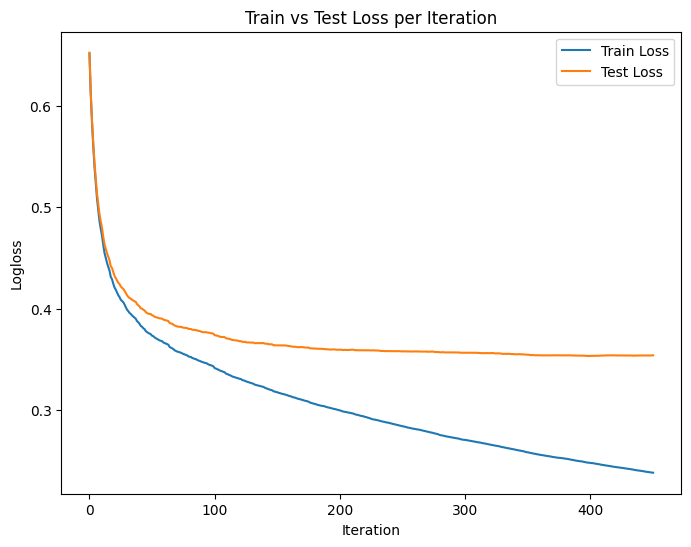

interactive(children=(FloatSlider(value=0.5, description='Threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [40]:
# Retrieve evaluation results to plot loss per iteration
evals_result = model.get_evals_result()
train_loss = evals_result['learn']['Logloss']
test_loss = evals_result['validation']['Logloss']

# Plot train and test loss per iteration
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('Train vs Test Loss per Iteration')
plt.legend()
plt.show()

# Confusion matrix
@interact(p=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, description="Threshold"))
def update_confusion_matrix(p=0.5):
    # Compute predictions using the current threshold
    y_pred = model.predict_proba(X_test)[:, 1] > p

    # Compute confusion matrix and evaluation metrics
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # Set axis labels and ticks
    classes = ['Negative (0)', 'Positive (1)']
    ax.set(xticks=[0, 1],
           yticks=[0, 1],
           xticklabels=classes,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Compute total for percentages
    total = cm.sum()

    # Annotate each cell with count and percentage
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percent = (count / total * 100) if total > 0 else 0
            ax.text(j, i, f"{count}\n({percent:.1f}%)",
                    ha="center", va="center",
                    color="white" if count > thresh else "black")

    # Set title and suptitle with evaluation scores
    ax.set_title("Confusion Matrix")
    fig.suptitle(f"Accuracy: {acc:.2f} | Precision: {prec:.2f}", fontsize=16)

    plt.show()

### $\pi^0$ mass with training

Now it is time to see how our GBT classifier improves our $\pi^0$ spectrum. In the following code cell, you can choose a particular $p$-threshold and see the new $\pi^0$ spectrum and its components. By default, we use $p=0.5$.


Using a variable we call $N$, we evaluate the number of events for a given histogram component within an invariant mass region. By default, we choose the region $0.106\lt M\lt 0.166$ GeV. We see that the number of **Type B** and **Type C** backgrounds drop significantly, while the number of **Type A** backgrounds (true combinatoric) only drop slightly. Importantly, we see that the number of true signal $\pi^0$'s does not decrease significantly.



In [43]:
p_threshold = 0.5

df_validation_copy = df_validation.copy()
df_validation_copy['p'] = model.predict_proba(X_validation)[:, 1]
df_validation_copy = df_validation_copy[df_validation_copy['p'] > p_threshold]

all_pi0_masses_trained, subset2_masses_trained, subset3_masses_trained, subset4_masses_trained, subset5_masses_trained = get_mass_vectors(df_validation_copy)

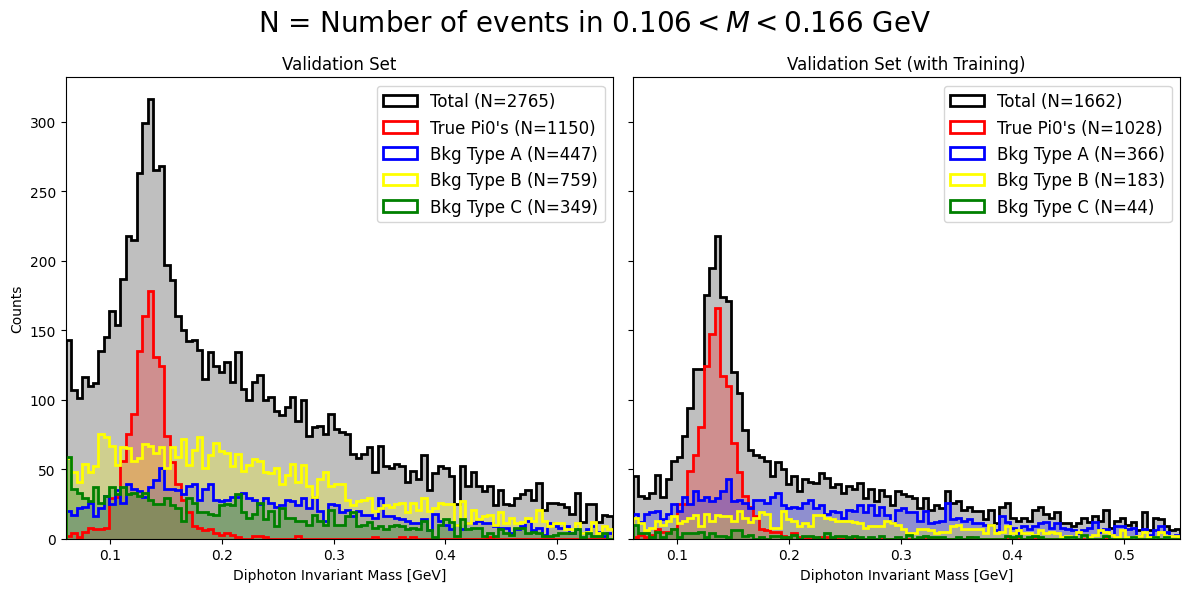

In [54]:
# Define xlimits and bins
xlimits = (0.06, 0.55)
bins = 100

# Define mass window limits for counting events
mass_min, mass_max = 0.106, 0.166

# Compute counts for the Validation Set
total_count = np.sum((np.array(all_pi0_masses) > mass_min) & (np.array(all_pi0_masses) < mass_max))
subset2_count = np.sum((np.array(subset2_masses) > mass_min) & (np.array(subset2_masses) < mass_max))
subset3_count = np.sum((np.array(subset3_masses) > mass_min) & (np.array(subset3_masses) < mass_max))
subset4_count = np.sum((np.array(subset4_masses) > mass_min) & (np.array(subset4_masses) < mass_max))
subset5_count = np.sum((np.array(subset5_masses) > mass_min) & (np.array(subset5_masses) < mass_max))

# Compute counts for the Validation Set (with Training)
total_count_trained = np.sum((np.array(all_pi0_masses_trained) > mass_min) & (np.array(all_pi0_masses_trained) < mass_max))
subset2_count_trained = np.sum((np.array(subset2_masses_trained) > mass_min) & (np.array(subset2_masses_trained) < mass_max))
subset3_count_trained = np.sum((np.array(subset3_masses_trained) > mass_min) & (np.array(subset3_masses_trained) < mass_max))
subset4_count_trained = np.sum((np.array(subset4_masses_trained) > mass_min) & (np.array(subset4_masses_trained) < mass_max))
subset5_count_trained = np.sum((np.array(subset5_masses_trained) > mass_min) & (np.array(subset5_masses_trained) < mass_max))

# Create figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# ---------------------------
# Plot histograms for the Validation Set (OLD)
# ---------------------------
axs[0].hist(all_pi0_masses, range=xlimits, bins=bins, color="black", alpha=0.25)
axs[0].hist(all_pi0_masses, range=xlimits, bins=bins, color="black", histtype='step', linewidth=2,
            label=f"Total (N={total_count})")

axs[0].hist(subset2_masses, range=xlimits, bins=bins, color="red", alpha=0.25)
axs[0].hist(subset2_masses, range=xlimits, bins=bins, color="red", histtype='step', linewidth=2,
            label=f"True Pi0's (N={subset2_count})")

axs[0].hist(subset3_masses, range=xlimits, bins=bins, color="blue", alpha=0.25)
axs[0].hist(subset3_masses, range=xlimits, bins=bins, color="blue", histtype='step', linewidth=2,
            label=f"Bkg Type A (N={subset3_count})")

axs[0].hist(subset4_masses, range=xlimits, bins=bins, color="yellow", alpha=0.25)
axs[0].hist(subset4_masses, range=xlimits, bins=bins, color="yellow", histtype='step', linewidth=2,
            label=f"Bkg Type B (N={subset4_count})")

axs[0].hist(subset5_masses, range=xlimits, bins=bins, color="green", alpha=0.25)
axs[0].hist(subset5_masses, range=xlimits, bins=bins, color="green", histtype='step', linewidth=2,
            label=f"Bkg Type C (N={subset5_count})")

# ---------------------------
# Plot histograms for the Validation Set (with Training) (NEW)
# ---------------------------
axs[1].hist(all_pi0_masses_trained, range=xlimits, bins=bins, color="black", alpha=0.25)
axs[1].hist(all_pi0_masses_trained, range=xlimits, bins=bins, color="black", histtype='step', linewidth=2,
            label=f"Total (N={total_count_trained})")

axs[1].hist(subset2_masses_trained, range=xlimits, bins=bins, color="red", alpha=0.25)
axs[1].hist(subset2_masses_trained, range=xlimits, bins=bins, color="red", histtype='step', linewidth=2,
            label=f"True Pi0's (N={subset2_count_trained})")

axs[1].hist(subset3_masses_trained, range=xlimits, bins=bins, color="blue", alpha=0.25)
axs[1].hist(subset3_masses_trained, range=xlimits, bins=bins, color="blue", histtype='step', linewidth=2,
            label=f"Bkg Type A (N={subset3_count_trained})")

axs[1].hist(subset4_masses_trained, range=xlimits, bins=bins, color="yellow", alpha=0.25)
axs[1].hist(subset4_masses_trained, range=xlimits, bins=bins, color="yellow", histtype='step', linewidth=2,
            label=f"Bkg Type B (N={subset4_count_trained})")

axs[1].hist(subset5_masses_trained, range=xlimits, bins=bins, color="green", alpha=0.25)
axs[1].hist(subset5_masses_trained, range=xlimits, bins=bins, color="green", histtype='step', linewidth=2,
            label=f"Bkg Type C (N={subset5_count_trained})")

# Modify axes limits and labels
axs[0].set_xlim(xlimits)
axs[0].set_xlabel("Diphoton Invariant Mass [GeV]")
axs[1].set_xlabel("Diphoton Invariant Mass [GeV]")
axs[0].set_ylabel("Counts")

axs[0].set_title("Validation Set")
axs[1].set_title("Validation Set (with Training)")

axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)

plt.suptitle(f"N = Number of events in ${mass_min}<M<{mass_max}$ GeV",fontsize=20)
plt.tight_layout()
plt.show()


### Comparison with minimum energy cuts

One approach other analyses take to reducing the $\pi^0$ background is by making a cut on the minimum photon energy. The idea is that false clusters are more likely to have lower energies when classified as photons. To exploit this, analyses like to place cuts as aggressive as $E_{\gamma}>0.5$ GeV. However, as a consequence, these cuts wind up reducing a good chunk of the true $\pi^0$'s.

To compare our model with the minimum photon energy cuts, feel free to toy with your own $E_{\mathrm{min}}$ cuts and see the impact on the diphoton spectrum.

In [55]:
E_threshold = 0.5 # GeV

df_validation_copy = df_validation.copy()
df_validation_copy = df_validation_copy[df_validation_copy['gE'] > E_threshold]

all_pi0_masses_trained, subset2_masses_trained, subset3_masses_trained, subset4_masses_trained, subset5_masses_trained = get_mass_vectors(df_validation_copy)

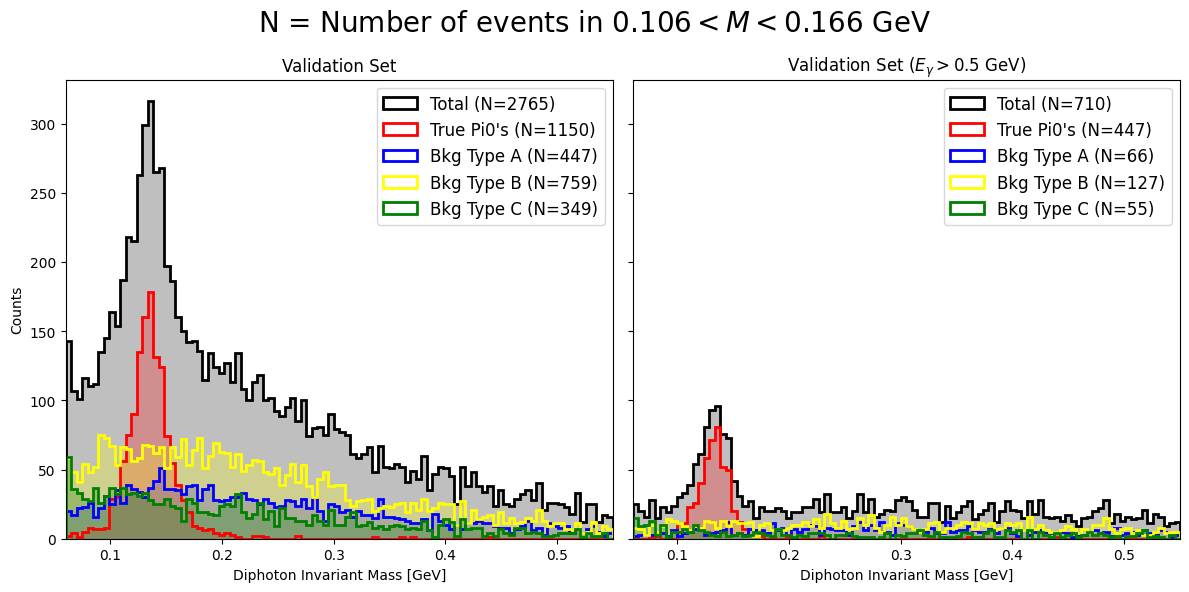

In [56]:
# Define xlimits and bins
xlimits = (0.06, 0.55)
bins = 100

# Define mass window limits for counting events
mass_min, mass_max = 0.106, 0.166

# Compute counts for the Validation Set
total_count = np.sum((np.array(all_pi0_masses) > mass_min) & (np.array(all_pi0_masses) < mass_max))
subset2_count = np.sum((np.array(subset2_masses) > mass_min) & (np.array(subset2_masses) < mass_max))
subset3_count = np.sum((np.array(subset3_masses) > mass_min) & (np.array(subset3_masses) < mass_max))
subset4_count = np.sum((np.array(subset4_masses) > mass_min) & (np.array(subset4_masses) < mass_max))
subset5_count = np.sum((np.array(subset5_masses) > mass_min) & (np.array(subset5_masses) < mass_max))

# Compute counts for the Validation Set (with Training)
total_count_trained = np.sum((np.array(all_pi0_masses_trained) > mass_min) & (np.array(all_pi0_masses_trained) < mass_max))
subset2_count_trained = np.sum((np.array(subset2_masses_trained) > mass_min) & (np.array(subset2_masses_trained) < mass_max))
subset3_count_trained = np.sum((np.array(subset3_masses_trained) > mass_min) & (np.array(subset3_masses_trained) < mass_max))
subset4_count_trained = np.sum((np.array(subset4_masses_trained) > mass_min) & (np.array(subset4_masses_trained) < mass_max))
subset5_count_trained = np.sum((np.array(subset5_masses_trained) > mass_min) & (np.array(subset5_masses_trained) < mass_max))

# Create figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# ---------------------------
# Plot histograms for the Validation Set (OLD)
# ---------------------------
axs[0].hist(all_pi0_masses, range=xlimits, bins=bins, color="black", alpha=0.25)
axs[0].hist(all_pi0_masses, range=xlimits, bins=bins, color="black", histtype='step', linewidth=2,
            label=f"Total (N={total_count})")

axs[0].hist(subset2_masses, range=xlimits, bins=bins, color="red", alpha=0.25)
axs[0].hist(subset2_masses, range=xlimits, bins=bins, color="red", histtype='step', linewidth=2,
            label=f"True Pi0's (N={subset2_count})")

axs[0].hist(subset3_masses, range=xlimits, bins=bins, color="blue", alpha=0.25)
axs[0].hist(subset3_masses, range=xlimits, bins=bins, color="blue", histtype='step', linewidth=2,
            label=f"Bkg Type A (N={subset3_count})")

axs[0].hist(subset4_masses, range=xlimits, bins=bins, color="yellow", alpha=0.25)
axs[0].hist(subset4_masses, range=xlimits, bins=bins, color="yellow", histtype='step', linewidth=2,
            label=f"Bkg Type B (N={subset4_count})")

axs[0].hist(subset5_masses, range=xlimits, bins=bins, color="green", alpha=0.25)
axs[0].hist(subset5_masses, range=xlimits, bins=bins, color="green", histtype='step', linewidth=2,
            label=f"Bkg Type C (N={subset5_count})")

# ---------------------------
# Plot histograms for the Validation Set (with Training) (NEW)
# ---------------------------
axs[1].hist(all_pi0_masses_trained, range=xlimits, bins=bins, color="black", alpha=0.25)
axs[1].hist(all_pi0_masses_trained, range=xlimits, bins=bins, color="black", histtype='step', linewidth=2,
            label=f"Total (N={total_count_trained})")

axs[1].hist(subset2_masses_trained, range=xlimits, bins=bins, color="red", alpha=0.25)
axs[1].hist(subset2_masses_trained, range=xlimits, bins=bins, color="red", histtype='step', linewidth=2,
            label=f"True Pi0's (N={subset2_count_trained})")

axs[1].hist(subset3_masses_trained, range=xlimits, bins=bins, color="blue", alpha=0.25)
axs[1].hist(subset3_masses_trained, range=xlimits, bins=bins, color="blue", histtype='step', linewidth=2,
            label=f"Bkg Type A (N={subset3_count_trained})")

axs[1].hist(subset4_masses_trained, range=xlimits, bins=bins, color="yellow", alpha=0.25)
axs[1].hist(subset4_masses_trained, range=xlimits, bins=bins, color="yellow", histtype='step', linewidth=2,
            label=f"Bkg Type B (N={subset4_count_trained})")

axs[1].hist(subset5_masses_trained, range=xlimits, bins=bins, color="green", alpha=0.25)
axs[1].hist(subset5_masses_trained, range=xlimits, bins=bins, color="green", histtype='step', linewidth=2,
            label=f"Bkg Type C (N={subset5_count_trained})")

# Modify axes limits and labels
axs[0].set_xlim(xlimits)
axs[0].set_xlabel("Diphoton Invariant Mass [GeV]")
axs[1].set_xlabel("Diphoton Invariant Mass [GeV]")
axs[0].set_ylabel("Counts")

axs[0].set_title("Validation Set")
axs[1].set_title(f"Validation Set ($E_{{\gamma}}>{E_threshold}$ GeV)")

axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)

plt.suptitle(f"N = Number of events in ${mass_min}<M<{mass_max}$ GeV",fontsize=20)
plt.tight_layout()
plt.show()
